# [Relatório Final] Projeto de SuperComputação (2023.1)

**Aluno:** Luca Coutinho Melão

## 1. Introdução
----

O relatório abaixo é uma continuação do [**Relatório Parcial**](./RelatorioParcial.ipynb), contido neste repositório. 

O objetivo dele é apresentar os resultados obtidos após a implementação da heurística de busca exaustiva para a resolução do problema da maratona de filmes. Para isso, foi implementado em primeiro lugar um algoritmo sequencial de busca exaustiva, que testa todas as possibilidades de escolha de filmes para a maratona, e retorna a melhor delas. Depois, sua execução foi otimizada por meio do paralelismo utilizando tanto Open MP quanto GPU.

## 2. Heurísticas
----

A abordagem exaustiva, também conhecida como força bruta, é uma heurística utilizada na resolução de problemas de otimização que envolve a enumeração de todas as possíveis soluções do problema em questão. No caso do problema da maratona de filmes, a abordagem exaustiva implica na criação de todas as possíveis maratonas válidas com combinações de filmes, levando em consideração as restrições de conflitos de horário e de limites de filmes por categoria, para depois avaliar cada combinação e chegar à a solução ideal.

Em um primeiro momento essa heurística aparenta ser de simples compreensão e implementação, porém ela tem uma complexidade computacional que cresce exponencialmente com o tamanho da entrada, já que ela avalia todas as possíveis soluções em função do input. Sendo assim, é importante ressaltar que essa abordagem pode tornar-se inviável para conjuntos de dados muito grandes, já que o tempo de processamento pode ser muito longo.

Tendo em vista esse problema, um caminho para otimizar a execução da heurística exaustiva é a utilização do paralelismo. Neste projeto, foram implementadas duas versões paralelas da heurística exaustiva, uma utilizando Open MP e outra utilizando GPU.

### 2.1. Implementação Sequencial da Busca Exaustiva 

Em primeiro lugar, foi implementada uma versão sequencial da heurística exaustiva (o código fonte pode ser encontrado [aqui](./exaustiva_sequencial.cpp)). Ele foi estruturado da seguinte maneira:

* **Estruturas de Dados:** A struct do filme foi a mesma utilizada nas implementações anteriores. Além disso, foi criada a struct `bestSchedule` para representar a melhor programação possível, a qual contém um vetor de filmes e o tempo total sem tela da programação.

* **Restrições**: De modo a respeitar as restrições impostas pelo problema, a função booleana `conflito` é utilizada para verificar se um novo filme pode ser adicionado à programação atual. Ela verifica se a adição do novo filme excederia o limite de filmes por categoria e também se haveria conflito de horários com os filmes já selecionados.

* **Tratamento do input:** O código lê o arquivo de input de entrada que especifica o número total de filmes (N), o número de categorias (C), os limites de filmes por categoria e os detalhes de cada filme (horário de início, horário de fim e categoria pertencente). Para tratamento e recebimento destes dados foi utilizada a mesma lógica das implementações anteriores.

* **Processamento:** Em seguida, o código gera todas as possíveis combinações de filmes, verificando cada uma para conflitos e limites. Se a combinação sendo avaliada for válida (ou seja, não há conflitos e os limites são respeitados) e resulta em menos tempo sem tela do que a melhor combinação encontrada até então, a melhor combinação é atualizada.

* **Resultados:** Por fim, o código imprime o número de filmes assistidos na melhor programação encontrada e o tempo que o algoritmo levou para executar com determinado input. Ele também grava os resultados em um arquivo de output com extensão .txt.

### 2.2. Implementação da Busca Exaustiva com Open MP

A primeira paralelização da heurística exaustiva foi feita utilizando Open MP (Open Multi-Processing), que é uma API para programação paralela em sistemas de memória compartilhada. O código fonte pode ser encontrado [aqui](./exaustiva_paralela.cpp).

Na implementação feita neste projeto, a diretiva `#pragma omp parallel for` é usada para dividir o loop que percorre todas as possíveis combinações de filmes entre as várias threads disponíveis. Isso permite a avaliação simultânea de múltiplas combinações de filmes, acelerando a execução do algoritmo.

No entanto, é importante tomar cuidado com condições de corrida, em que várias threads tentam acessar e modificar a mesma variável ao mesmo tempo. No código apresentado, isso é tratado usando a diretiva `#pragma omp critical`, a qual garante que apenas uma thread possa executar a seção de código de cada vez para atualizar a melhor maratona encontrada até então.

Vale ressaltar também que o uso de Open MP não necessariamente garante um desempenho melhor em todos os casos, pois a paralelização tem um overhead envolvido que pode acabar diminuindo a performance do programa para algumas entradas. Isso ficará mais claro na sessão de discussão dos resultados.

### 2.3. Implementação da Busca Exaustiva com GPU

A segunda paralelização da heurística exaustiva foi feita utilizando a GPU (Graphics Processing Unit), que é um processador especializado em processamento gráfico. Ela é útil e deve ser utilizada para partes paralelas do código nas quais a taxa de transferência bate a latência menor, maximizando o throughput. O código fonte pode ser encontrado [aqui](./exaustiva_gpu.cu).

A implementação da paralelização usando GPU foi feita por meio da CUDA (Compute Unified Device Architecture), uma plataforma de computação paralela da Nvidia. E para isso foi utilizada a biblioteca Thrust, que é uma biblioteca de template C++ para CUDA que fornece algoritmos de alto desempenho para processamento paralelo.

O código foi estruturado de modo que a função `main` é responsável por ler o input e aplicar o functor `exaustiva_gpu`, responsável por implementar a heurística exaustiva utilizando a GPU. Ele recebe o número de filmes N, o número de categorias C, um ponteiro para os limites de categoria `cat_limites` e um ponteiro para os filmes. No seu operador de chamada de função, ele realiza a busca exaustiva testando todas as possíveis combinações de filmes. Se a combinação atual violar a regra de categoria excedida ou conflito de tempo, ele retorna -1. Caso contrário, retorna a quantidade de filmes na maratona atual.

De volta na função `main`, após a leitura e ordenação dos dados, o código aloca na GPU os vetores de filmes e categorias através da classe `thrust::device_vector`. Ele também cria um `thrust::device_vector` para os resultados

O functor é então aplicado a cada valor no intervalo de 0 a 2^N (número total de combinações) usando `thrust::transform`, que aplica ele a cada elemento do intervalo e armazena o resultado no vetor de resultados.

Por fim, o código procura o elemento máximo no vetor de resultados usando `thrust::max_element`, que representa a maior quantidade de filmes que podem ser assistidos sem violar as regras. O tempo total de execução é calculado e ambos são impressos e escritos em um arquivo.

Ademais, é importante ressaltar também que a GPU possui um endereçamento de memória separado, de modo que os dados precisam ser copiados dela ou para ela, criando um overhead nesse ponto. Ou seja, nem sempre a GPU será a melhor opção para paralelizar um código, pois o overhead de transferência de dados pode acabar diminuindo a performance do programa para algumas entradas. Isso também ficará mais claro na sessão de discussão dos resultados.

## 3. Tratando o ouptut
----

### 3.1. Processamento dos dados

Imports necessários para a execução do código:

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Funções de processamento:

In [3]:
def process_output(file):
    ''''
    Processa o arquivo de saída do algoritmo e retorna uma lista com os valores de cada "coluna"
    '''
    
    # Conteúdo do arquivo em uma variável
    with open(file, "r") as file:
        conteudo_txt = file.read()

    filmes = []
    categorias = []
    exec_time = []
    films_watched = []

    # Quebrando o conteúdo do arquivo em linhas
    linhas = conteudo_txt.split("\n")

    for linha in linhas:
        if linha:
            linha = linha.split(" ")
            c1, c2, c3, c4 = linha 
            filmes.append(int(c1))
            categorias.append(int(c2))
            exec_time.append(float(c3))
            films_watched.append(int(c4))

    params = [filmes, categorias, exec_time, films_watched]
    return params

# Gerando um DataFrame para fins comparativos

def create_comparative_table(params, name):
    filmes, categorias, exec_time, films_watched = params

    # Creating a DataFrame to store the data
    data = {
        'Filmes': filmes,
        'Categorias': categorias,
        'Tempo de Execução (ms)': exec_time,
        'Filmes Assistidos': films_watched
    }
    df = pd.DataFrame(data)

    return df

def sort(params):
    filmes, categorias, exec_time, films_watched = params

    transposto = list(map(list, zip(*params)))

    dados_sorted = sorted(transposto, key=lambda x: x[-1])

    params = list(map(list, zip(*dados_sorted)))

    return params

In [4]:
# Extrai os dados de cada arquivo de saída/heurística
exaustiva_sequencial_params = process_output("./outputs/output_exaustiva_sequencial.txt")
exaustiva_paralela_params = process_output("./outputs/output_exaustiva_paralela.txt")
exaustiva_gpu_params = process_output("./outputs/output_exaustiva_gpu.txt")
guloso_params = process_output("./outputs/output_gulosa_novo.txt")
aleatorio_params = process_output("./outputs/output_gulosa_novo.txt")

In [5]:
# Adequado o tempo de execução para milisegundos
aleatorio_params[2] = [i * 1000000 for i in aleatorio_params[2]]
guloso_params[2] = [i * 1000000 for i in guloso_params[2]]

In [6]:
# Ordenando os dados de cada arquivo de saída/heurística
exaustiva_sequencial_params = sort(exaustiva_sequencial_params)
exaustiva_paralela_params = sort(exaustiva_paralela_params)
exaustiva_gpu_params = sort(exaustiva_gpu_params)
guloso_params = sort(guloso_params)
aleatorio_params = sort(aleatorio_params)

### 3.2. Output da Implementação Sequencial
----

In [7]:
comparative_table_exaustiva_sequencial = create_comparative_table(exaustiva_sequencial_params, "Exaustiva Sequencial")
table_title = "Exaustiva Sequencial"
print(f"{table_title}\n{'=' * len(table_title)*4}")
print(comparative_table_exaustiva_sequencial.sort_values(by=['Filmes', 'Categorias']).to_string(index=False))

Exaustiva Sequencial
 Filmes  Categorias  Tempo de Execução (ms)  Filmes Assistidos
     10           4                   5.151                  4
     12           4                  23.395                  5
     14           4                 107.538                  6
     16           4                 468.118                  5
     18           4                2180.210                  6
     20           4                9247.010                  6
     22           4               40501.400                  6
     24           4              180998.000                  8


### 3.3. Output da Implementação com Open MP
----

In [8]:
comparative_table_exaustiva_paralela = create_comparative_table(exaustiva_paralela_params, "Exaustiva Paralela")
table_title = "Exaustiva Paralela"
print(f"\n{table_title}\n{'=' * len(table_title)*4}")
print(comparative_table_exaustiva_paralela.sort_values(by=['Filmes', 'Categorias']).to_string(index=False))


Exaustiva Paralela
 Filmes  Categorias  Tempo de Execução (ms)  Filmes Assistidos
     10           4                 5.13413                  4
     12           4                 3.65852                  5
     14           4                20.41250                  6
     16           4                93.02240                  4
     18           4               381.95700                  6
     20           4              1660.40000                  6
     22           4              7473.24000                  7
     24           4             29686.70000                  8


In [9]:
comparative_table_exaustiva_gpu = create_comparative_table(exaustiva_gpu_params, "Exaustiva GPU")
table_title = "Exaustiva GPU"
print(f"\n{table_title}\n{'=' * len(table_title)*5}")
print(comparative_table_exaustiva_gpu.sort_values(by=['Filmes', 'Categorias']).to_string(index=False))


Exaustiva GPU
 Filmes  Categorias  Tempo de Execução (ms)  Filmes Assistidos
     10           4                 142.510                  4
     12           4                 132.823                  5
     14           4                 125.512                  6
     16           4                 132.666                  4
     18           4                 125.563                  6
     20           4                 126.290                  6
     22           4                 130.841                  7
     24           4                 132.241                  8


## 4. Gráficos e Resultados
----

Visualizando o tempo de execução das implementações conforme o tamanho da entrada aumenta:

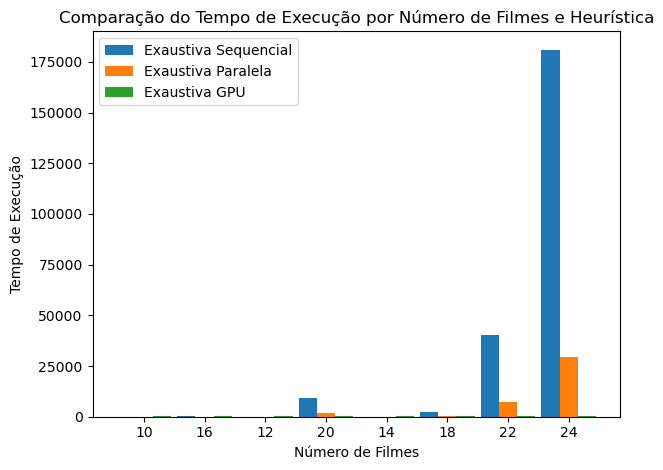

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Utilizando os dados já ordenados
num_filmes = exaustiva_sequencial_params[0]

# Localização no eixo x para os grupos
x = np.arange(len(num_filmes))  

# Largura das barras
width = 0.3  

fig, ax = plt.subplots()

rects1 = ax.bar(x - width, exaustiva_sequencial_params[2], width, label='Exaustiva Sequencial')
rects2 = ax.bar(x, exaustiva_paralela_params[2], width, label='Exaustiva Paralela')
rects3 = ax.bar(x + width, exaustiva_gpu_params[2], width, label='Exaustiva GPU')

# Adicionando rótulos, título e legenda no gráfico
ax.set_ylabel('Tempo de Execução')
ax.set_xlabel('Número de Filmes')
ax.set_title('Comparação do Tempo de Execução por Número de Filmes e Heurística')
ax.set_xticks(x)
ax.set_xticklabels(num_filmes)
ax.legend()

fig.tight_layout()

plt.show()


Melhorando a visualização para observar mais de perto.

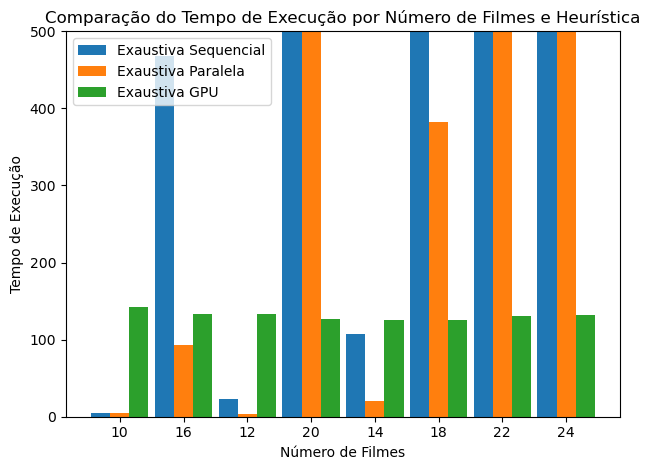

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Remove as duas últimas linhas
exaustiva_sequencial_params_sorted = [param for param in exaustiva_sequencial_params]
exaustiva_paralela_params_sorted = [param for param in exaustiva_paralela_params]
exaustiva_gpu_params_sorted = [param for param in exaustiva_gpu_params]

num_filmes = exaustiva_sequencial_params_sorted[0]

x = np.arange(len(num_filmes)) 
width = 0.3  

fig, ax = plt.subplots()

rects1 = ax.bar(x - width, exaustiva_sequencial_params_sorted[2], width, label='Exaustiva Sequencial')
rects2 = ax.bar(x, exaustiva_paralela_params_sorted[2], width, label='Exaustiva Paralela')
rects3 = ax.bar(x + width, exaustiva_gpu_params_sorted[2], width, label='Exaustiva GPU')

# Adicionando rótulos, título e legenda no gráfico
ax.set_ylim(0, 500)
ax.set_ylabel('Tempo de Execução')
ax.set_xlabel('Número de Filmes')
ax.set_title('Comparação do Tempo de Execução por Número de Filmes e Heurística')
ax.set_xticks(x)
ax.set_xticklabels(num_filmes)
ax.legend()

fig.tight_layout()

plt.show()


Comparando com o tempo de execução das heurísticas implementadas anteriormente.

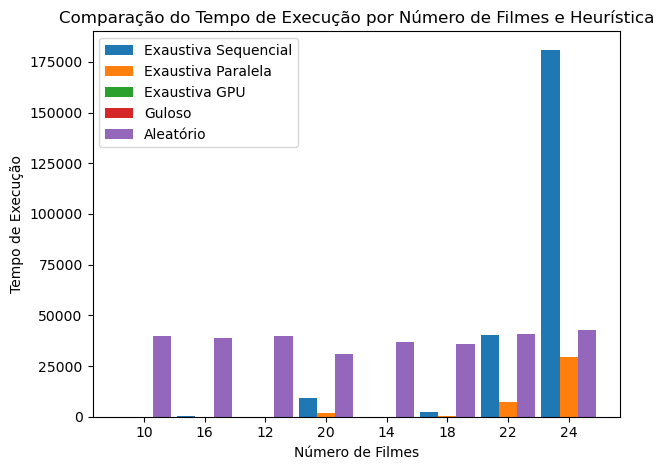

In [12]:
num_filmes = exaustiva_sequencial_params[0]

x = np.arange(len(num_filmes))  
width = 0.3  

fig, ax = plt.subplots()

rects1 = ax.bar(x - width, exaustiva_sequencial_params[2], width, label='Exaustiva Sequencial')
rects2 = ax.bar(x, exaustiva_paralela_params[2], width, label='Exaustiva Paralela')
rects3 = ax.bar(x + width, exaustiva_gpu_params[2], width, label='Exaustiva GPU')
rects4 = ax.bar(x + width, guloso_params[2], width, label='Guloso')
rects5 = ax.bar(x + width, aleatorio_params[2], width, label='Aleatório')


# Adicionando rótulos, título e legenda no gráfico
ax.set_ylabel('Tempo de Execução')
ax.set_xlabel('Número de Filmes')
ax.set_title('Comparação do Tempo de Execução por Número de Filmes e Heurística')
ax.set_xticks(x)
ax.set_xticklabels(num_filmes)
ax.legend()

fig.tight_layout()

plt.show()


Ampliando a visualização.

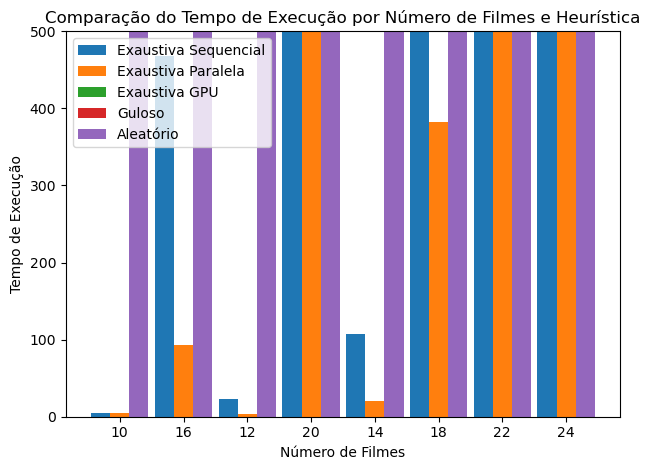

In [13]:
num_filmes = exaustiva_sequencial_params[0]

# Localização no eixo x para os grupos
x = np.arange(len(num_filmes))   
# Largura das barras
width = 0.3  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, exaustiva_sequencial_params[2], width, label='Exaustiva Sequencial')
rects2 = ax.bar(x, exaustiva_paralela_params[2], width, label='Exaustiva Paralela')
rects3 = ax.bar(x + width, exaustiva_gpu_params[2], width, label='Exaustiva GPU')
rects4 = ax.bar(x + width, guloso_params[2], width, label='Guloso')
rects5 = ax.bar(x + width, aleatorio_params[2], width, label='Aleatório')


# Adicionando rótulos, título e legenda no gráfico
ax.set_ylim(0, 500)
ax.set_ylabel('Tempo de Execução')
ax.set_xlabel('Número de Filmes')
ax.set_title('Comparação do Tempo de Execução por Número de Filmes e Heurística')
ax.set_xticks(x)
ax.set_xticklabels(num_filmes)
ax.legend()

fig.tight_layout()

plt.show()


Observando o aumento do tempo de execução conforme o número de filmes da entrada aumenta.

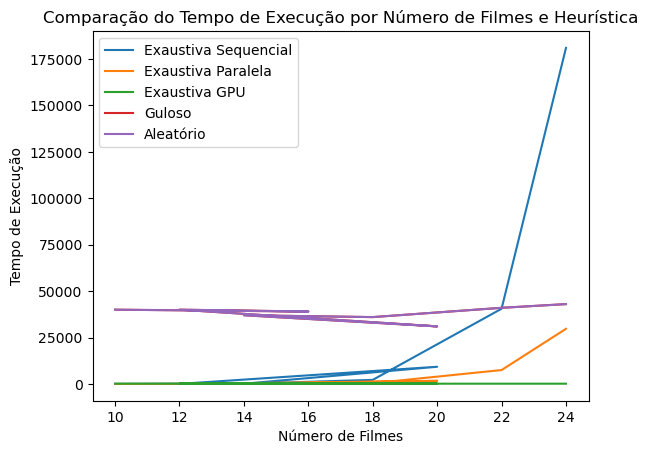

In [17]:
num_filmes = exaustiva_sequencial_params[0]

fig, ax = plt.subplots()

# Gráficos de linha em vez de barras
line1 = ax.plot(num_filmes, exaustiva_sequencial_params[2], label='Exaustiva Sequencial')
line2 = ax.plot(num_filmes, exaustiva_paralela_params[2], label='Exaustiva Paralela')
line3 = ax.plot(num_filmes, exaustiva_gpu_params[2], label='Exaustiva GPU')
line4 = ax.plot(num_filmes, guloso_params[2], label='Guloso')
line5 = ax.plot(num_filmes, aleatorio_params[2], label='Aleatório')

# Adicionando rótulos, título e legenda no gráfico
ax.set_ylabel('Tempo de Execução')
ax.set_xlabel('Número de Filmes')
ax.set_title('Comparação do Tempo de Execução por Número de Filmes e Heurística')
ax.legend()

plt.show()


Comparando o máximo de filmes obtidos em cada heurística.

## 5. Conclusão
----

Analisando os gráficos e o desempenho das heurísticas, podemos concluir que no caso do nosso problema da maratona de filmes, a "melhor heurística" varia de acordo com o tamanho de entrada passada para o algoritmo. O critério adotado para fins comparativos foi o número de filmes selecionados para a maratona, pois é o que o problema visa maximizar. 

Como esperado, quando comparamos as as três implementações da heurística exaustiva, podemos ver que de forma geral a versão sequencial é a mais lenta e a que mais tem seu tempo de execução crescendo exponencialmente conforme a entrada aumenta, pois ela não utiliza paralelismo. Já a versão paralela com OpenMP é mais rápida que a sequencial, pois ela divide o trabalho entre várias threads, o que acelera a execução do algoritmo. Por fim, a versão paralela com GPU é a mais rápida dentre as três no geral, pois ela utiliza a GPU para realizar o processamento, que é muito mais veloz que a CPU.

Por mais que não seja mais rápida para pequenos inputs, devido ao overhead gerado pelo endereçamento de memória separado e a necessidade de transferência de dados, podemos notar que conforme o número de filmes aumenta o overhead da CPU é cada vez mais compensado com o ganho de desempenho que ele proporciona, tornando-se a melhor heurística entre as três para inputs grandes.

Inclusive no gráfico de tempo de execução obtemos um tempo que avança mais constante para a implementação com GPU, de modo que conforme a entrada aumenta ela converge para um tempo de execução menor do que o das outras implementações, nas quais o tempo de execução cresce de forma mais exponencial.